In [15]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import math
import statistics
from sklearn.model_selection import train_test_split
from google.colab import  drive
import warnings
#warnings.filterwarnings( "ignore" )
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 10, 8
#np.seterr(divide='ignore', invalid='ignore')
#import warnings
#warnings.filterwarnings('ignore')
#warnings.warn('DelftStack')
#warnings.warn('Do not show this message')
#print("No Warning Shown")

In [16]:
#Data preprocessing
data = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
col =  ["treatment", "y_factual", "y_cfactual",]
for i in range(1,28):
    col.append("x"+str(i))
data.columns = col
#data.head()
x_data=pd.concat([data.iloc[:,0], data.iloc[:, 1:30]], axis = 1)
y_data=data.iloc[:, 1]

In [17]:
# Function to calculate CV
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100

In [18]:
#Function to calculate CV
def cv_cal(model_type):
  cv_weight=[]
  cv_ipw=[]
  cv_of_weight=0
  cv_of_ipw=0
  weights=np.zeros(150)
  invweights=np.zeros(150)
  for i in range(1,200):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=i)
    #X_train_t=x_train.iloc[:, 2:30]
    X_train_t=x_train.iloc[:, 5:30]
    Y_train_t=x_train.iloc[:, 0]
    X_test_t=x_test.iloc[:, 5:30]
    Y_test_t=x_test.iloc[:, 0]
    if(model_type==0):
       model = LogisticRegression(max_iter=2)
    elif(model_type==1):
       model = LogisticRegression()
    else:
      model = lgb.LGBMClassifier()

    model.fit(X_train_t, Y_train_t)
    expected_y  = Y_test_t
    expected_yt  = Y_train_t
    predicted_y =model.predict(X_test_t)
    predicted_yt=model.predict(X_train_t)
    probs=model.predict_proba(X_test_t)
    data_probs = x_test[['treatment','y_cfactual']]


    data_probs.loc[:,['P0','P1']] = probs
    data_probs['ipw']= np.where (data_probs['treatment']==1, 1/data_probs['P1'], 1/data_probs['P0'])
    data_probs['e']= np.where (data_probs['treatment']==1, 1-data_probs['P1'], 1-data_probs['P0'])
    #data_probs.loc[:, 'ep'] = np.power(data_probs.loc[:, 'e'],p)
    data_probs.loc[:, 'ep'] =(data_probs.loc[:, 'e'])


    weightsn = np.array(data_probs['ep'])
    invweightsn = np.array(data_probs['ipw'])

    weights =np.array(weights) + np.array(data_probs['ep'])
    invweights =np.array(invweights) + np.array(data_probs['ipw'])


    cv_of_weight=cv_of_weight+cv(weightsn)
    cv_of_ipw=cv_of_ipw+cv(invweightsn)
    cv_weight.append(cv_of_weight/i)
    cv_ipw.append(cv_of_ipw/i)

  data_probs['ep']=(weights/200)
  data_probs['ipw']=(invweights/200)
  weights=(weights/200)
  invweights=(invweights/200)
  return cv_ipw,cv_weight,model


In [5]:

#0 =underfit, 1=moderate, 2=overfit
model_type=2
cv_ipw,cv_weight,model=cv_cal(model_type)
if(model_type==0):
  typeis='underfit'
elif(model_type==1):
  typeis='good'
else:
  typeis='overfit'


490.6180446779877


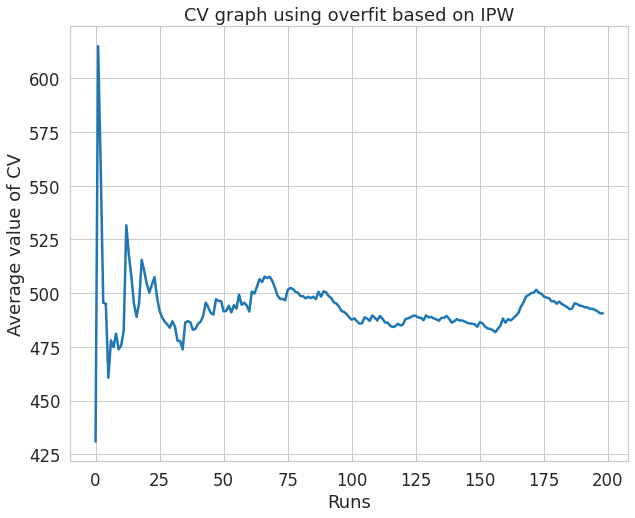

In [6]:
#CV of IPW
plt.plot((cv_ipw))
plt.xlabel('Runs')
plt.title('CV graph using '+typeis +' based on IPW')
plt.ylabel('Average value of CV')
print (cv_ipw.pop())

128.68805754082857


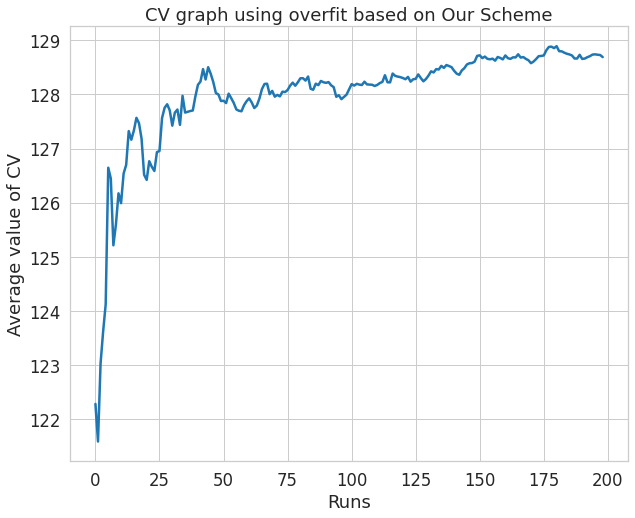

In [7]:
#CV of Our Scheme
plt.plot((cv_weight))
plt.xlabel('Runs')
plt.title('CV graph using '+typeis +' based on Our Scheme')
plt.ylabel('Average value of CV')
print (cv_weight.pop())

In [8]:
mean_weight_0=[]
std_weight_0=[]
mean_weight_1=[]
std_weight_1=[]

mean_ipw_0=[]
std_ipw_0=[]
mean_ipw_1=[]
std_ipw_1=[]
def prop_cal():
  for i in range(1,50):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=i)
    x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_test, y_test, test_size=0.30, random_state=i)
    X_train_t=x_train.iloc[:, 5:30]
    Y_train_t=x_train.iloc[:, 0]
    X_test_t=x_test.iloc[:, 5:30]
    Y_test_t=x_test.iloc[:, 0]
    probsp=model.predict_proba(X_test_t)
    data_probsp = x_test[['treatment','y_cfactual']]
    data_probsp.loc[:,['P0','P1']] = probsp

    data_probsp['ipw']= np.where (data_probsp['treatment']==1, 1/data_probsp['P1'], 1/data_probsp['P0'])
    data_probsp['e']= np.where (data_probsp['treatment']==1, 1-data_probsp['P1'], 1-data_probsp['P0'])
    data_probsp.loc[:, 'ep'] =(data_probsp.loc[:, 'e'])
    weightsp =np.array(data_probsp['ep'])
    invweightsp =np.array(data_probsp['ipw'])

    model5 = LogisticRegression()
    model5.fit( X_test_t, Y_test_t,sample_weight=weightsp)
    x_testvt=x_testv.iloc[:, 5:30]
    probs5=model5.predict_proba(x_testvt)
    data_probs5 = x_testv[['treatment','y_cfactual']]
    data_probs5.loc[:,['P0','P1']] = probs5
    mean_weight_0.append(statistics.mean(np.array(data_probs5['P0'])))
    std_weight_0.append(statistics.stdev(np.array(data_probs5['P0'])))
    mean_weight_1.append(statistics.mean(np.array(data_probs5['P1'])))
    std_weight_1.append(statistics.stdev(np.array(data_probs5['P1'])))
    #-----------------------------------------
    model6 = LogisticRegression()
    model6.fit( X_test_t, Y_test_t,sample_weight=invweightsp)
    x_testvt=x_testv.iloc[:, 5:30]
    probs6=model6.predict_proba(x_testvt)
    data_probs6 = x_testv[['treatment','y_cfactual']]
    data_probs6.loc[:,['P0','P1']] = probs6
    mean_ipw_0.append(statistics.mean(np.array(data_probs6['P0'])))
    std_ipw_0.append(statistics.stdev(np.array(data_probs6['P0'])))
    mean_ipw_1.append(statistics.mean(np.array(data_probs6['P1'])))
    std_ipw_1.append(statistics.stdev(np.array(data_probs6['P1'])))



In [9]:
#Propensity score estimation
prop_cal()
#Normal distribution of avg mean and std
rng = np.random.default_rng(seed=42)
w0 = rng.normal(statistics.mean(mean_weight_0), statistics.mean(std_weight_0), 100)
w1 = rng.normal(statistics.mean(mean_weight_1), statistics.mean(std_weight_1), 100)
ipw0 = rng.normal(statistics.mean(mean_ipw_0), statistics.mean(std_ipw_0), 100)
ipw1 = rng.normal(statistics.mean(mean_ipw_1), statistics.mean(std_ipw_1), 100)

Text(0, 0.5, 'Count')

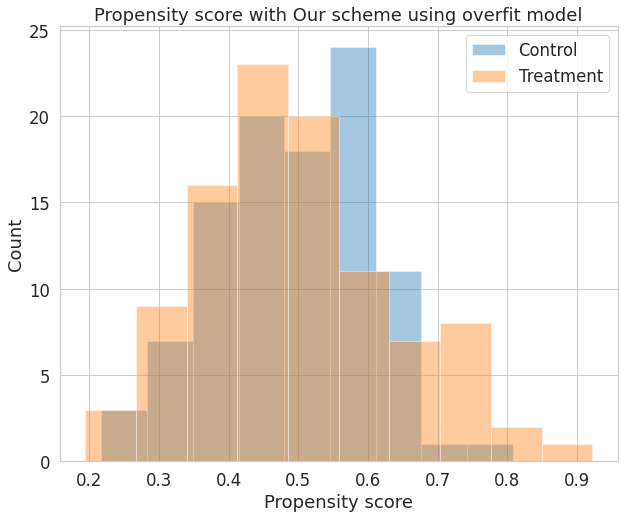

In [10]:
# Normal distribution graph of propensity scores using Our scheme
ax1 = sns.distplot(w0, label="Control",kde=False)
ax1=sns.distplot(w1, label="Treatment",kde=False)
ax1.set_xlabel('Propensity score')
plt.legend()
plt.title('Propensity score with Our scheme using '+typeis +' model')
plt.legend()
ax1.set_ylabel('Count')
#----------------------------------------------------

Text(0, 0.5, 'Count')

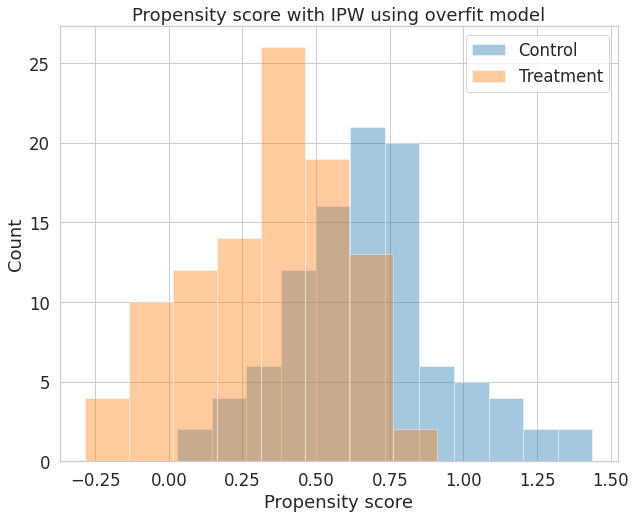

In [11]:
# Normal distribution graph of propensity scores using IPW
ax2 = sns.distplot(ipw0, label="Control",kde=False)
ax2=sns.distplot(ipw1, label="Treatment",kde=False)
ax2.set_xlabel('Propensity score')
plt.legend()
plt.title('Propensity score with IPW using '+typeis +' model')
plt.legend()
ax2.set_ylabel('Count')

In [12]:

# Functions to calculate standardized mean difference
def cal_SMD_Unweighted(x,dunw):
  for i in range(200):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=i)
    data_treat=x_test[x_test['treatment']==1]
    data_control=x_test[x_test['treatment']==0]
    data_treat[x].mean()
    data_control[x].mean()
    A=(data_treat[x].mean()-data_control[x].mean())
    B=math.sqrt((np.var(data_treat[x])+np.var(data_control[x]))/2)
    dunw=dunw+(100*(A/B))
  return (dunw/200)

def cal_SMD_weighted(x,dw):
  for i in range(200):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=i)
    X_train_d=x_train.iloc[:, 5:30]
    Y_train_d=x_train.iloc[:, 0]
    X_test_d=x_test.iloc[:, 5:30]
    Y_test_d=x_test.iloc[:, 0]
    if(model_type==0):
       modeld = LogisticRegression(max_iter=2)
    elif(model_type==1):
       modeld = LogisticRegression()
    else:
      modeld = lgb.LGBMClassifier()

    modeld.fit( X_train_d, Y_train_d )
    probsd=modeld.predict_proba(X_test_d)
    p=1
    data_probsd = pd.concat([X_test_d, Y_test_d], axis = 1)
    data_probsd.loc[:,['P0','P1']] = probsd
    data_probsd['ipw']= np.where (data_probsd['treatment']==1, 1/data_probsd['P1'], 1/data_probsd['P0'])
    #data_probsd['ipw']= 1/data_probsd['P1']
    data_probsd.loc[:, 'e'] = np.abs(data_probsd['treatment'] - data_probsd['P1'])
    data_probsd.loc[:, 'ep'] =(data_probsd.loc[:, 'e']*p)
    data_treat=data_probsd[data_probsd['treatment']==1]
    data_control=data_probsd[data_probsd['treatment']==0]
    treat_mean=sum(data_treat[x]*data_treat['ep'])/sum(data_treat['ep'])
    control_mean=sum(data_control[x]*data_control['ep'])/sum(data_control['ep'])
    A=(treat_mean-control_mean)
    var_treat=(sum(data_treat['ep'])/((sum(data_treat['ep'])**2)-(sum(data_treat['ep']**2))))*sum((data_treat[x]-treat_mean)**2 *(data_treat['ep']))
    var_control=(sum(data_control['ep'])/((sum(data_control['ep'])**2)-(sum(data_control['ep']**2))))*sum((data_control[x]-control_mean)**2 *(data_control['ep']))
    B=math.sqrt((var_treat+var_control)/2)
    dw=dw+(100*(A/B))
  return (dw/200)

def cal_SMD_weightedinv(x,dipw):
  for i in range(200):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=i)
    X_train_d=x_train.iloc[:, 5:30]
    Y_train_d=x_train.iloc[:, 0]
    X_test_d=x_test.iloc[:, 5:30]
    Y_test_d=x_test.iloc[:, 0]
    if(model_type==0):
       modeld = LogisticRegression(max_iter=2)
    elif(model_type==1):
       modeld = LogisticRegression()
    else:
      modeld = lgb.LGBMClassifier()

    modeld.fit( X_train_d, Y_train_d )
    probsd=modeld.predict_proba(X_test_d)
    p=1
    data_probsd = pd.concat([X_test_d, Y_test_d], axis = 1)
    data_probsd.loc[:,['P0','P1']] = probsd
    data_probsd['ipw']= np.where (data_probsd['treatment']==1, 1/data_probsd['P1'], 1/data_probsd['P0'])
    data_probsd.loc[:, 'e'] = np.abs(data_probsd['treatment'] - data_probsd['P1'])
    data_probsd.loc[:, 'ep'] =(data_probsd.loc[:, 'e'])
    data_treat=data_probsd[data_probsd['treatment']==1]
    data_control=data_probsd[data_probsd['treatment']==0]
    treat_mean=sum(data_treat[x]*data_treat['ipw'])/sum(data_treat['ipw'])
    control_mean=sum(data_control[x]*data_control['ipw'])/sum(data_control['ipw'])
    A=(treat_mean-control_mean)
    var_treat=(sum(data_treat['ipw'])/((sum(data_treat['ipw'])**2)-(sum(data_treat['ipw']**2))))*sum((data_treat[x]-treat_mean)**2 *(data_treat['ipw']))
    var_control=(sum(data_control['ipw'])/((sum(data_control['ipw'])**2)-(sum(data_control['ipw']**2))))*sum((data_control[x]-control_mean)**2 *(data_control['ipw']))
    B=math.sqrt((var_treat+var_control)/2)
    dipw=dipw+(100*(A/B))
  return (dipw/200)


In [13]:
dunw=0
dipw=0
dw=0
variables = ["bw", "b.head", "preterm", "birth.o", "nnhealth", "momage"]
SMD_weighted=[]
SMD_unweighted=[]
SMD_weightedinv=[]

for i in range(3,9):
    #col.append("x"+str(i))
    x='x'+str(i)
    #print (i)
    SMD_weighted.append(np.abs(cal_SMD_weighted(x,dw)))
    SMD_unweighted.append(np.abs(cal_SMD_Unweighted(x,dunw)))
    SMD_weightedinv.append(np.abs(cal_SMD_weightedinv(x,dipw)))


Text(0.5, 1.0, 'Standardized difference with our scheme using overfit model')

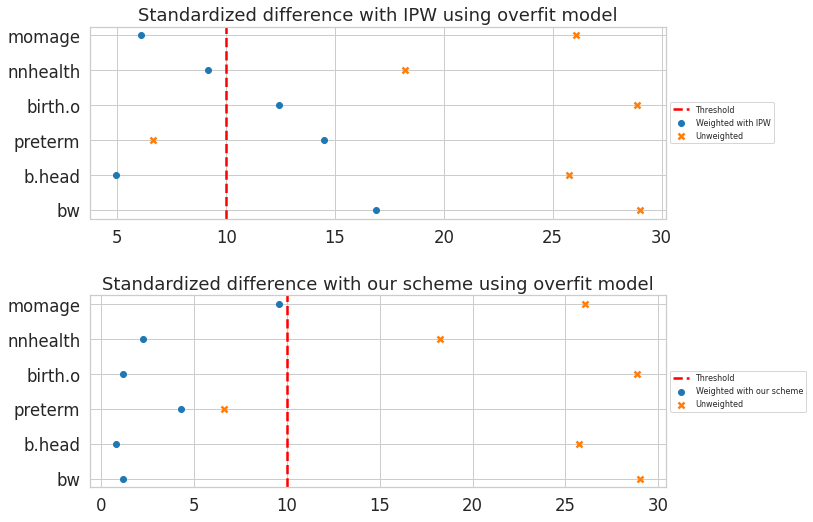

In [14]:
#plotting standardized mean difference
fig, axs = plt.subplots(2)
#fig.suptitle('Absolute Standardized Difference on IHDP')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)



axs[0].scatter(SMD_weightedinv,variables, label='Weighted with IPW', marker='o')
axs[0].scatter(SMD_unweighted,variables, label='Unweighted', marker='x')
axs[0].axvline(10, linestyle='dashed',color='r', label='Threshold')
axs[0].legend(prop={'size': 8},loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_title('Standardized difference with IPW using '+typeis +' model')

axs[1].scatter(SMD_weighted,variables, label='Weighted with our scheme', marker='o')
axs[1].scatter(SMD_unweighted,variables, label='Unweighted', marker='x')
axs[1].axvline(10, linestyle='dashed',color='r', label='Threshold')
axs[1].legend(prop={'size': 8},loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].set_title('Standardized difference with our scheme using '+typeis +' model')